In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from statannot import add_stat_annotation
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
#import statsmodels.api as sm
from collections import Counter

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,9908fffab7ed4f3bec44cda2f5084d49,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.984443,g__Enterococcus
1,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
2,fd44d4cb468fd7dc9b3227867714ed87,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
3,3b010dbd9eae72a79f11af5d24eb3ca3,d__Bacteria; p__Verrucomicrobiota; c__Verrucom...,0.999999,g__Akkermansia
4,b15193fce14759d1c06728933e044af6,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides


# Read sample data

In [3]:
df_sample = pd.read_csv('StoolSamplesTable.csv', index_col=0, encoding = 'unicode_escape')
df_sample.index.name = 'SampleID'
df_sample.head()

,Patient_ID,SampleDayRelativeToD1Chemo,16S_qPCR (copies/µl),Quality
SampleID,,,,
SRR7048546,7D001,4,unavailable,Adequate
SRR7048547,7D001,5,1009173,Adequate
SRR7048548,7D001,7,1678142,Adequate
SRR7048537,7D001,9,1067090,Adequate
SRR7048536,7D001,12,843037,Adequate


# Read count data

In [4]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1078


#OTU ID,9908fffab7ed4f3bec44cda2f5084d49,99deb3c5ecb022ec05609ebd1112a557,fd44d4cb468fd7dc9b3227867714ed87,3b010dbd9eae72a79f11af5d24eb3ca3,b15193fce14759d1c06728933e044af6,fd496fd32dc8c08ade2e8b6c9d8ee13d,836cd5ea357ad392c00a7e48d921be1d,9e18b43f389956ba5ac3ddf810f39cb6,09e996f449e880d1fd8f27d59e8d8b11,2c982937754e6321f861027032db80f7,...,14192646199d9cf06334c54aade286a5,21f93f2c1599c14f6c307b7e2cda69a2,a12a086985ef700cc8f5a0bd3c7b45c1,9853e2316d094a543ef4a956e03fadfd,6caa23f82d746bd829487c78de3b993a,90edbf2900f4aae18773de227c0b102f,e838089789ff8d5492411a71cd065527,d1fba67286934f6e1fd4a0a281af0e77,05f4400139040b710ee01cbaaf816295,fa08448d9b798f3e436c6bb6858495cb
SRR7048604,0.066831,0.003462,0.026159,0.0,0.000000,0.015055,0.000000,0.001539,0.000350,0.240851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR14593480,0.611451,0.000000,0.000000,0.0,0.000000,0.076340,0.000728,0.000000,0.016463,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8075064,0.425912,0.000000,0.000000,0.0,0.000000,0.042722,0.000931,0.000000,0.305194,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR7048584,0.661432,0.000000,0.000000,0.0,0.000523,0.000000,0.000000,0.000000,0.090463,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR12851155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.218088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compute oral percentage and qPCR

In [7]:
# get oral bacterial fraction
df_blast_100 = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relabun[set(df_blast_100.query_accver).intersection(df_relabun.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total.index.name = 'SampleID'
df_oral_total['log10_OralFrac_HMPv35oral'] = np.log10(df_oral_total['OralFrac_HMPv35oral'])
df = pd.merge(df_sample, df_oral_total, left_index=True, right_index=True, how='inner')
df.columns = ['PatinetID','SampleDayRelativeToD1Chemo','qPCR16S','Quality','OralFrac_HMPv35oral','log10_OralFrac_HMPv35oral']
df = df[df['qPCR16S'] != "unavailable"]
df['qPCR16S'] = df['qPCR16S'].astype(float)
df['log10_qPCR16S'] = np.log10(df['qPCR16S'])
df = df[df.OralFrac_HMPv35oral>0]
df.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PatinetID,SampleDayRelativeToD1Chemo,qPCR16S,Quality,OralFrac_HMPv35oral,log10_OralFrac_HMPv35oral,log10_qPCR16S
SampleID,,,,,,,
SRR7048547,7D001,5,1009173.0,Adequate,0.007487,-2.125676,6.003966
SRR7048548,7D001,7,1678142.0,Adequate,0.030586,-1.514471,6.224829
SRR7048537,7D001,9,1067090.0,Adequate,0.041907,-1.377709,6.028201
SRR7048536,7D001,12,843037.0,Adequate,0.004093,-2.387990,5.925847
SRR7048535,7D001,15,498384.0,Adequate,0.009588,-2.018290,5.697564


# Plot correlation between oral fraction and qPCR

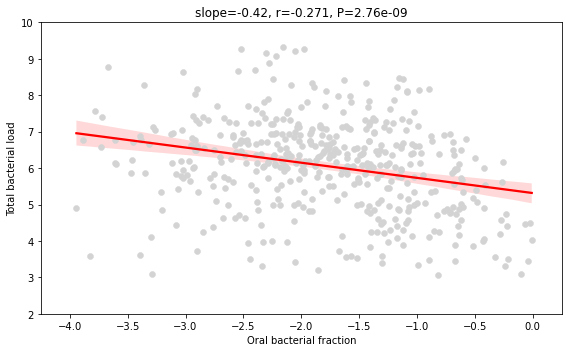

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

df2 = df[df.qPCR16S >= 1e3]
_ = sns.regplot(data=df2, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, scatter_kws={"color": "black"}, line_kws={"color": "red"}, scatter=False)
_ = sns.scatterplot(data=df2, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, color='lightgray', edgecolor='lightgray')
_ = ax.set_ylabel('Total bacterial load')
_ = ax.set_xlabel('Oral bacterial fraction')
slope, intercept, r_value, p_value, std_err = stats.linregress(df2.log10_OralFrac_HMPv35oral, df2.log10_qPCR16S)
_ = ax.set_title('slope=%2.2f, r=%2.3f, P=%2.2e'%(slope, r_value, p_value))
_ = ax.set_xlim([-4.25, 0.25])
_ = ax.set_ylim([2,10])
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_oralfrac_qpcr_msk.svg", dpi=600)

# Binned distribution

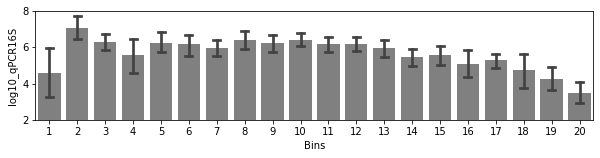

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2))

# calculate binned values
bins = np.linspace(-4,0,21)
digitized = np.digitize(list(df.log10_OralFrac_HMPv35oral), bins)
df['Bins']=digitized

# plot
_ = sns.barplot(x='Bins', y='log10_qPCR16S', data=df, ax=ax, color='grey', capsize=0.25)
_ = ax.set_ylim([2,8])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("binned_barplot_oral_qpcr.svg")